In [59]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import naturalneighbor as nn
import dask
from datetime import datetime
dask.config.set(scheduler = "single-threaded")

In [62]:
# Load data sets
# --------------------------------------

ds4 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flxwindC1.b1.*.nc',        combine='by_coords', parallel = True)
ds3 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpinterpolatedsondeC1.c1.*.nc', combine='by_coords', parallel = True)
ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc',   combine='by_coords', parallel = True)

# Combine near-surface quantities into single array
low_spd = np.zeros((3, 432))
low_spd[0, :] = ds4['wind_speed_4m'].values
low_spd[1, :] = ds4['wind_speed_25m'].values
low_spd[2, :] = ds4['wind_speed_60m'].values

low_dir = np.zeros((3, 432))
low_dir[0, :] = ds4['wind_direction_4m'].values
low_dir[1, :] = ds4['wind_direction_25m'].values
low_dir[2, :] = ds4['wind_direction_60m'].values

(0.0, 2000.0)

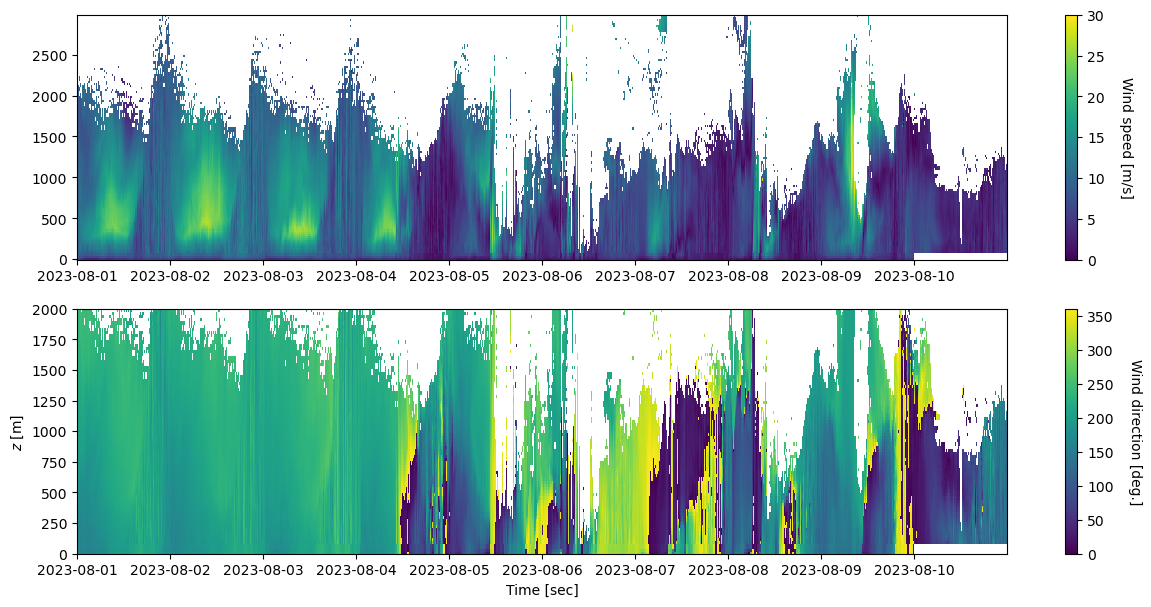

In [68]:
# Plot separate data sets
# --------------------------------------

fig,ax = plt.subplots(2, 1, figsize = (15, 7))

cntf = ax[0].pcolormesh(ds1.time, ds1.height,(ds1['WS']).T, vmin=0, vmax=30)
ax[0].pcolormesh(ds4.time, [4, 25, 60], low_spd, vmin=0, vmax=30)
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
plt.ylabel("$z$ [m]")
plt.ylim([0, 2000])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[1].pcolormesh(ds1.time, ds1.height,(ds1['WD']).T, vmin=0, vmax=360)
ax[1].pcolormesh(ds4.time, [4, 25, 60], low_dir, vmin=0, vmax=360)
cbar = plt.colorbar(cntf)
cbar.set_label('Wind direction [deg.]', rotation = 270, labelpad = 20)
plt.xlabel("Time [sec]")
plt.ylabel("$z$ [m]")
plt.ylim([0, 2000])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

In [35]:
# Process Doppler LiDAR data
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
interp_time1 = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values

x1, y1 = np.meshgrid(interp_time1, ds1['height'].values, indexing = 'ij')

xi1 = np.ravel(x1, order = 'C')
yi1 = np.ravel(y1, order = 'C')
zi1 = np.zeros(len(xi1))

winds1 = (ds1['WS'].copy(deep = True)).values
winds1_flat = np.ravel(winds1, order = 'C')

nan_ind1 = np.argwhere(~np.isnan(winds1_flat))

winds1_flat = winds1_flat[nan_ind1]
xi1 = xi1[nan_ind1].squeeze()
yi1 = yi1[nan_ind1].squeeze()
zi1 = zi1[nan_ind1].squeeze()

In [36]:
# Process near-surface data
# --------------------------------------

ref_date2 = np.datetime64(datetime(pd.to_datetime(ds4.time[0].values).year, pd.to_datetime(ds4.time[0].values).month, pd.to_datetime(ds4.time[0].values).day))
interp_time2 = ((ds4.time - ref_date2) / np.timedelta64(1, 'D')).values

x2, y2 = np.meshgrid(interp_time2, [4, 25, 60], indexing = 'ij')

xi2 = np.ravel(x2,order = 'C')
yi2 = np.ravel(y2,order = 'C')
zi2 = np.zeros(len(xi2))

winds2 = (low_spd).T
winds2_flat = np.ravel(winds2, order = 'C')

nan_ind2 = np.argwhere(~np.isnan(winds2_flat))

winds2_flat = winds2_flat[nan_ind2]
xi2 = xi2[nan_ind2].squeeze()
yi2 = yi2[nan_ind2].squeeze()
zi2 = zi2[nan_ind2].squeeze()

In [38]:
# Process high-altitude sonde data
# --------------------------------------

ref_date3 = np.datetime64(datetime(pd.to_datetime(ds3.time[0].values).year, pd.to_datetime(ds3.time[0].values).month, pd.to_datetime(ds3.time[0].values).day))
interp_time3 = ((ds3.time - ref_date3) / np.timedelta64(1, 'D')).values

x3, y3 = np.meshgrid(interp_time3, ds3['height'].values, indexing = 'ij')

xi3 = np.ravel(x3,order = 'C')
yi3 = np.ravel(y3,order = 'C')
zi3 = np.zeros(len(xi3))

winds3 = (ds3['WS'].copy(deep = True)).values
winds3_flat = np.ravel(winds3, order = 'C')

nan_ind3 = np.argwhere(~np.isnan(winds3_flat))

winds3_flat = winds3_flat[nan_ind3]
xi3 = xi3[nan_ind3].squeeze()
yi3 = yi3[nan_ind3].squeeze()
zi3 = zi3[nan_ind3].squeeze()

In [39]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)
assert(ref_date1 == ref_date3)

In [40]:
# Determine combined data time limits
# --------------------------------------

min_date = max([interp_time1[0], interp_time2[0], interp_time3[0]])
max_date = min([interp_time1[-1], interp_time2[-1], interp_time3[-1]])

interval = min([interp_time1[1] - interp_time1[0], interp_time2[1] - interp_time2[0], interp_time3[1] - interp_time3[0]])

In [42]:
# Combine processed data
# --------------------------------------

winds_combined = np.concatenate((winds3_flat, winds1_flat, winds2_flat)).squeeze()

x_c = np.concatenate((xi3, xi1, xi2)).squeeze()
y_c = np.concatenate((yi3, yi1, yi2)).squeeze()
z_c = np.concatenate((zi3, zi1, zi2)).squeeze()

In [43]:
# Interpolate
# --------------------------------------

tdef    = [min_date, max_date, interval]
zdef    = [0, 2000, 20] # [m]
griddef = [tdef, zdef, [-0.5, 0.5, 1]]

points = np.stack((x_c, y_c, z_c), axis = -1)

winds_nn_interp = nn.griddata(points, winds_combined, griddef).squeeze() # squeeze out "z" dimension

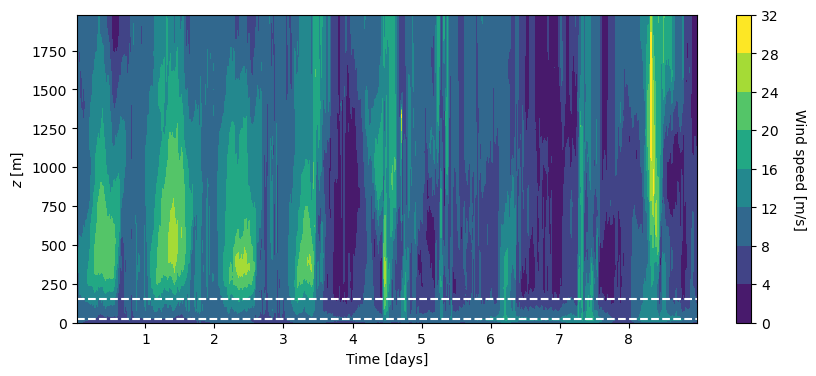

In [47]:
# Plot interpolated data [contour]
# --------------------------------------

times   = np.arange(tdef[0], tdef[1], tdef[2])
heights = np.arange(zdef[0], zdef[1], zdef[2])

hub_height = 88.5
diameter   = 127

fig,ax = plt.subplots(figsize = (10, 4))

cntf = ax.contourf(times, heights, winds_nn_interp.T, vmin=0, vmax=30)
plt.axhline(y = hub_height - diameter/2, color = 'w', linestyle = '--')
plt.axhline(y = hub_height + diameter/2, color = 'w', linestyle = '--')

cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
plt.xlabel("Time [days]")
plt.ylabel("$z$ [m]")
plt.show()
# plt.ylim([0, 500])

(0.0, 2000.0)

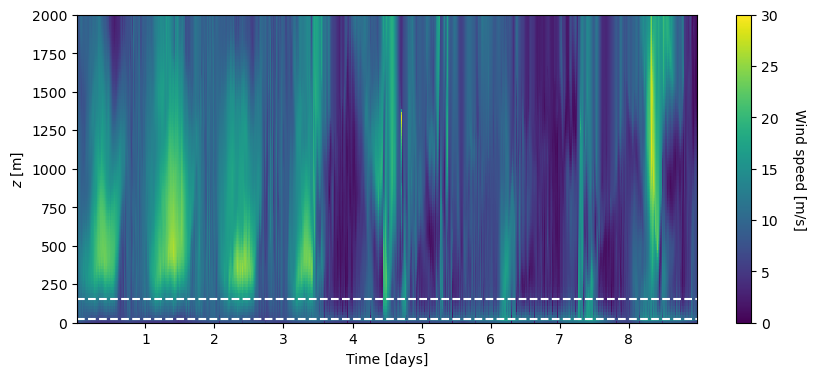

In [46]:
# Plot interpolated data [mesh]
# --------------------------------------

times   = np.arange(tdef[0], tdef[1], tdef[2])
heights = np.arange(zdef[0], zdef[1], zdef[2])

hub_height = 88.5
diameter   = 127

fig,ax = plt.subplots(figsize = (10, 4))

cntf = ax.pcolormesh(times, heights, winds_nn_interp.T, vmin=0, vmax=30)
plt.axhline(y = hub_height - diameter/2, color = 'w', linestyle = '--')
plt.axhline(y = hub_height + diameter/2, color = 'w', linestyle = '--')

cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
plt.xlabel("Time [days]")
plt.ylabel("$z$ [m]")
# plt.ylim([0, 500])
plt.ylim([0, 2000])
# plt.xlim([7, 8])

In [48]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(winds_nn_interp.shape[0], dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)

for i in range(winds_nn_interp.shape[0]):
    new_ref_times[i] = np.datetime64(pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

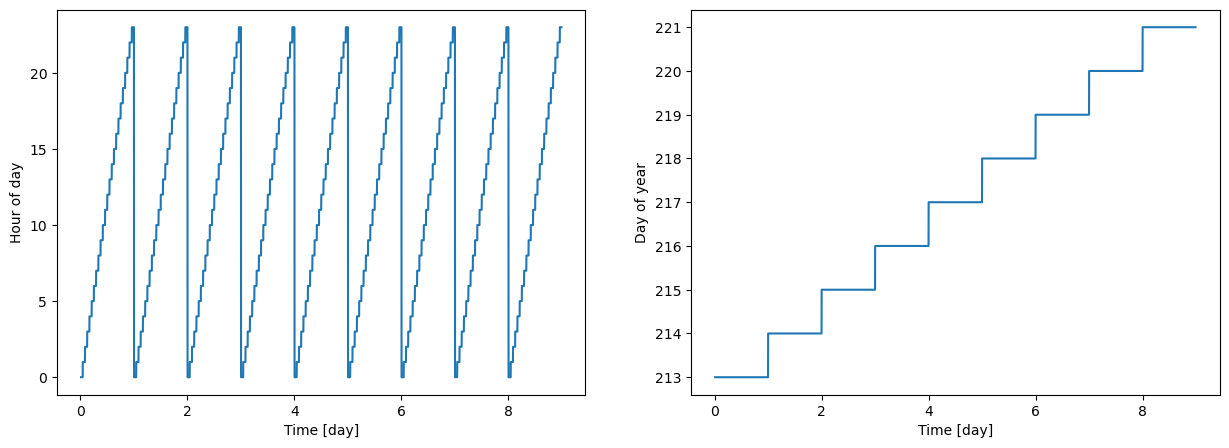

In [55]:
fig,ax = plt.subplots(1,2,figsize = (15, 5))

ax[0].plot(times, hr_per_day)
ax[0].set_xlabel('Time [day]')
ax[0].set_ylabel('Hour of day')

ax[1].plot(times, day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [52]:
# Save data
# --------------------------------------

full_xr = xr.Dataset({
    'WS': xr.DataArray(
                data   = winds_nn_interp.T,   # enter data here
                dims   = ['height', 'time'],
                coords = {'height': heights, 'time': new_ref_times},
    ),
    'hr_day': xr.DataArray(
                data   = hr_per_day,   # enter data here
                dims   = ['time'],
                coords = {'time': new_ref_times},
    ),
    'day_yr': xr.DataArray(
                data   = day_per_yr,   # enter data here
                dims   = ['time'],
                coords = {'time': new_ref_times},
    ),
        })
full_xr.to_netcdf('/Users/smata/Downloads/processedData/ML_data.nc')

full_xr

<xarray.Dataset>
Dimensions:  (height: 100, time: 12931)
Coordinates:
  * height   (height) int64 0 20 40 60 80 100 ... 1880 1900 1920 1940 1960 1980
  * time     (time) datetime64[ns] 2023-08-01T00:15:00 ... 2023-08-09T23:44:5...
Data variables:
    WS       (height, time) float64 6.032 8.784 8.773 ... 0.5527 0.5289 0.4971
    hr_day   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 23.0 23.0 23.0 23.0 23.0
    day_yr   (time) float64 213.0 213.0 213.0 213.0 ... 221.0 221.0 221.0 221.0